## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

# def get_first_cabin(row):
#     try:
#         return row.split()[0]
#     except:
#         return np.nan
    
# data['cabin'] = data['cabin'].apply(get_first_cabin)
data['cabin'] = data['cabin'].str.split(n=1, expand=True)[0]

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

# def get_title(passenger):
#     line = passenger
#     if re.search('Mrs', line):
#         return 'Mrs'
#     elif re.search('Mr', line):
#         return 'Mr'
#     elif re.search('Miss', line):
#         return 'Miss'
#     elif re.search('Master', line):
#         return 'Master'
#     else:
#         return 'Other'

def get_title(passenger):
    m = re.search('(Mrs|Mr|Miss|Master)', passenger)
    return m.group(0) if m else 'Other'

data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
title        object
dtype: object

In [11]:
vars_num = [c for c in data.columns if data[c].dtypes != 'O' and c != target]

vars_cat = [c for c in data.columns if data[c].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [12]:
# first in numerical variables

data[vars_num].isnull().mean()  # proportion of NA

pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64

In [13]:
# now in categorical variables

data[vars_cat].isnull().mean()  # proportion of NA

sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

In [14]:
vars_num_na = [c for c in vars_num if data[c].isnull().sum() > 0]
vars_cat_na = [c for c in vars_cat if data[c].isnull().sum() > 0]

vars_num_na, vars_cat_na

(['age', 'fare'], ['cabin', 'embarked'])

### Determine cardinality of categorical variables

In [15]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

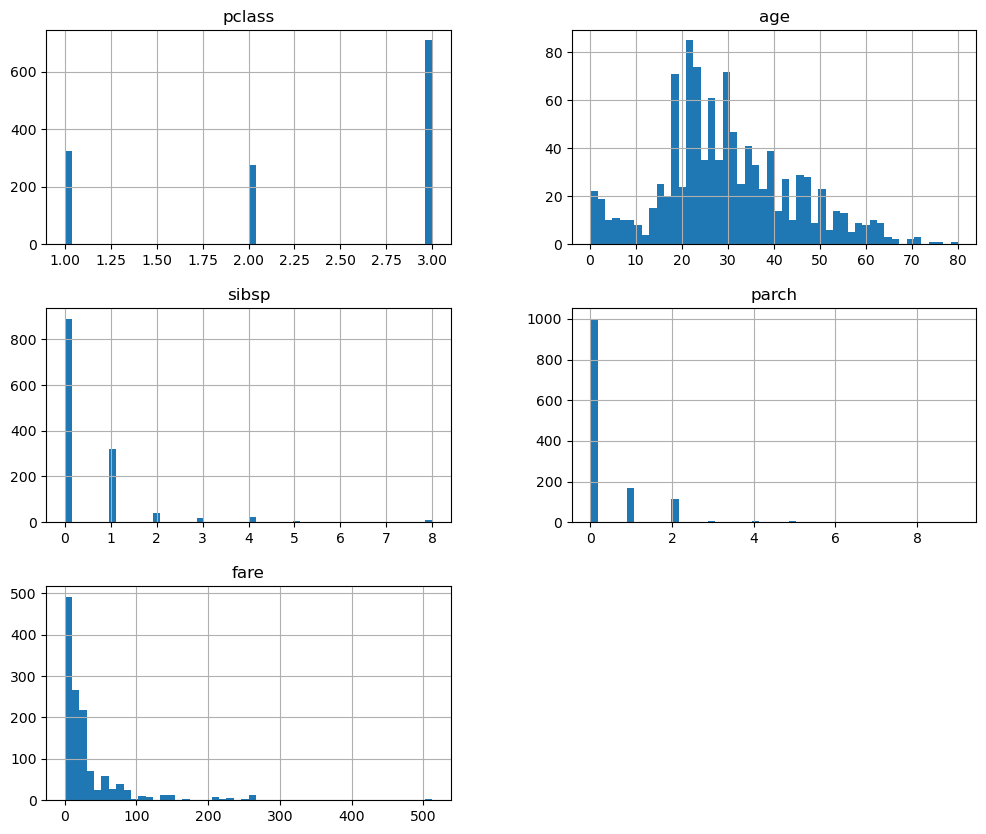

In [16]:
_ = data[vars_num].hist(bins=50, figsize=(12, 10))

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(target, axis=1),  # predictors
    data[target],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [18]:
deck = lambda cabin_col: cabin_col.str.extract('([A-Z])', expand=False)

X_train['cabin'] = deck(X_train['cabin'])
X_test['cabin'] = deck(X_test['cabin'])

X_train['cabin'].unique(), X_test['cabin'].unique()

(array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object),
 array([nan, 'G', 'E', 'C', 'B', 'A', 'F', 'D'], dtype=object))

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [19]:
for c in vars_num_na:

    # add missing indicator
    X_train[c+'_NA'] = np.where(X_train[c].isnull(), 1, 0)
    X_test[c+'_NA'] = np.where(X_test[c].isnull(), 1, 0)

    # replace NaN by median
    median_val = X_train[c].median()

    X_train[c].fillna(median_val, inplace=True)
    X_test[c].fillna(median_val, inplace=True)

X_train[vars_num_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [20]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

X_train[vars_cat].isnull().sum()

sex         0
cabin       0
embarked    0
title       0
dtype: int64

In [21]:
pd.DataFrame([X_train.isnull().sum(), X_test.isnull().sum()])  # all NAs are imputed

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_NA,fare_NA
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [22]:
def filter_rare_labels(df, c, rare_threshold):
    # % of observations per category
    gdf = df.groupby(c)[c].count() / len(df)
    # return categories that are rare
    return gdf[gdf >= rare_threshold]


for c in vars_cat:
    freq_labels_stats = filter_rare_labels(X_train, c, 0.05)
    freq_labels = freq_labels_stats.index
    print(freq_labels_stats)
    print()

    X_train[c] = np.where(X_train[c].isin(freq_labels), X_train[c], 'Rare')
    X_test[c] = np.where(X_test[c].isin(freq_labels), X_test[c], 'Rare')


sex
female    0.366762
male      0.633238
Name: sex, dtype: float64

cabin
C          0.074499
Missing    0.766953
Name: cabin, dtype: float64

embarked
C    0.195798
Q    0.092646
S    0.709647
Name: embarked, dtype: float64

title
Miss    0.202483
Mr      0.569245
Mrs     0.157593
Name: title, dtype: float64



In [23]:
X_train[vars_cat].nunique(), X_test[vars_cat].nunique()

(sex         2
 cabin       3
 embarked    4
 title       4
 dtype: int64,
 sex         2
 cabin       3
 embarked    3
 title       4
 dtype: int64)

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [24]:
for c in vars_cat:
    X_train = pd.concat(
        [ X_train, pd.get_dummies(X_train[c], prefix=c, drop_first=True) ], 
        axis=1
    )
    
    X_test = pd.concat(
        [ X_test, pd.get_dummies(X_test[c], prefix=c, drop_first=True) ], 
        axis=1
    )

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [25]:
X_train.columns, X_test.columns

(Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_NA', 'fare_NA',
        'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_Q',
        'embarked_Rare', 'embarked_S', 'title_Mr', 'title_Mrs', 'title_Rare'],
       dtype='object'),
 Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_NA', 'fare_NA',
        'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_Q', 'embarked_S',
        'title_Mr', 'title_Mrs', 'title_Rare'],
       dtype='object'))

In [26]:
# 'embarked_Rare' is not present on X_test, adding it manually
# X_test['embarked_Rare'] = 0  would append as the last column

# inserting in place, obeying the column order of X_train
idx = X_train.columns.to_list().index('embarked_Rare')
X_test.insert(idx, 'embarked_Rare', 0)

In [27]:
(X_train.columns == X_test.columns).all()

True

### Scale the variables

- Use the standard scaler from Scikit-learn

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [29]:
model = LogisticRegression(C=0.0005, random_state=0)
model.fit(X_train, y_train)
model

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [30]:
# Performance of train set
y_train_hat = model.predict(X_train)
y_train_hat_proba = model.predict_proba(X_train)[:,1]

print(f"Train ROC-AUC  : {roc_auc_score(y_train, y_train_hat_proba):.4f}")
print(f"Train accuracy : {accuracy_score(y_train, y_train_hat):.4f}")
print()

# Performance of test set
y_test_hat = model.predict(X_test)
y_test_hat_proba = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print(f"Test ROC-AUC   : {roc_auc_score(y_test, y_test_hat_proba):.4f}")
print(f"Test accuracy  : {accuracy_score(y_test, y_test_hat):.4f}")

Train ROC-AUC  : 0.8434
Train accuracy : 0.7125

Test ROC-AUC   : 0.8353
Test accuracy  : 0.7023



In [38]:
from sklearn.metrics import classification_report

print("Train report:")
print(classification_report(y_train, y_train_hat, target_names=['died', 'survived']))
print()

print("Test report:")
print(classification_report(y_test, y_test_hat, target_names=['died', 'survived']))


# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
# 'macro':
#     Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# 'weighted':
#     Calculate metrics for each label, and find their average weighted by support (the number of true instances for each 
#     label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision 
#     and recall.

Train report:
              precision    recall  f1-score   support

        died       0.68      0.99      0.81       647
    survived       0.95      0.26      0.41       400

    accuracy                           0.71      1047
   macro avg       0.82      0.63      0.61      1047
weighted avg       0.78      0.71      0.66      1047


Test report:
              precision    recall  f1-score   support

        died       0.68      1.00      0.81       162
    survived       1.00      0.22      0.36       100

    accuracy                           0.70       262
   macro avg       0.84      0.61      0.58       262
weighted avg       0.80      0.70      0.64       262



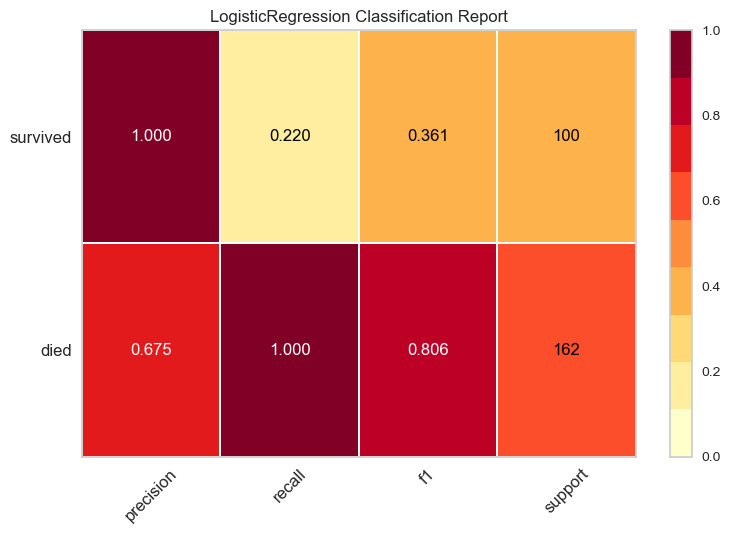

In [31]:
from yellowbrick.classifier import classification_report
_ = classification_report(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['died', 'survived'], support=True)

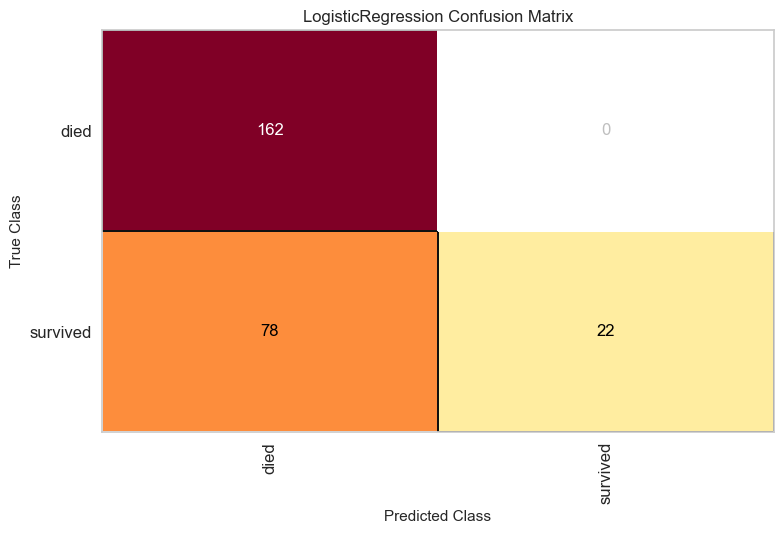

In [32]:
from yellowbrick.classifier import confusion_matrix
_ = confusion_matrix(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['died', 'survived'])

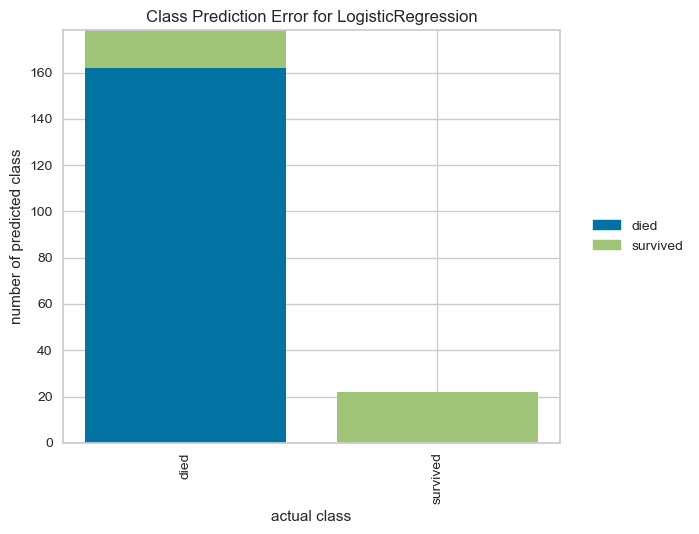

In [33]:
from yellowbrick.classifier import class_prediction_error

_ = class_prediction_error(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['died', 'survived'])

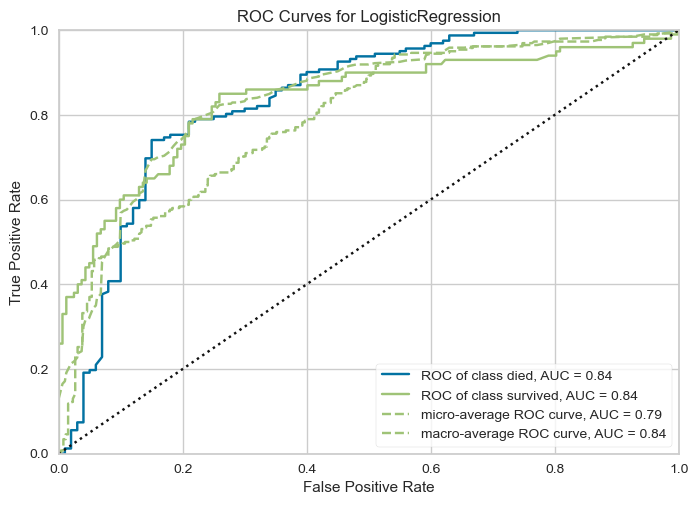

In [34]:
from yellowbrick.classifier.rocauc import roc_auc
_ = roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['died', 'survived'])

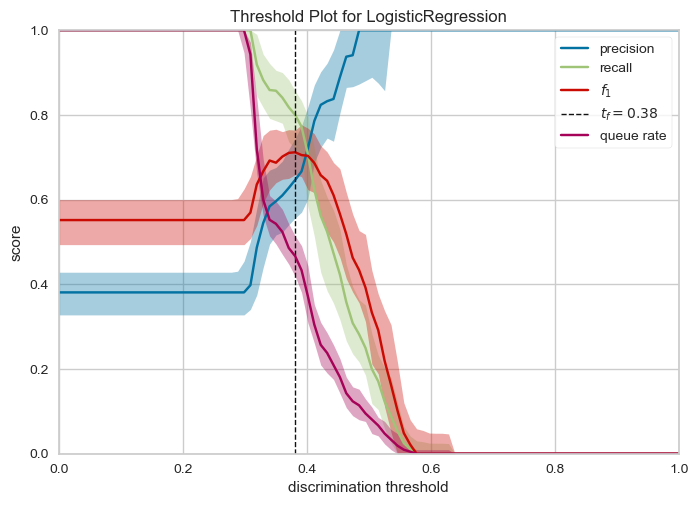

In [35]:
from yellowbrick.classifier.threshold import discrimination_threshold

_ = discrimination_threshold(model, X_train, y_train)

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignment!!**